# $\rho'$ analysis notes

### Data scheme

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import pandas as ps
import awkward

ccup9_2015_my_test = r"D:\GoogleDrive\Job\cern\Alice\analysis\dev\grid\selection\RhoPrime\macro\AnalysisResults.root"
ccup9_2015_my = r'D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2015\RhoPrime2015o.root'
ccup9_2015_my_new = r'D:\GoogleDrive\Job\cern\Alice\analysis\data\RhoPrime\2015\4Prongs2015o.root'

events = uproot.open(ccup9_2015_my_new)['4Prongs/events']
events.show()
print(events.name, events.title, events.numentries)

# mycache = uproot.ArrayCache(1024*1024 * 10)
data = events.arrays('*', namedecode="utf-8")
# data = events.lazyarrays('*', namedecode="utf-8")

print(data['nTracks'].sum())

## I forgot to clear T_ITSsa vector before new tracks filling for event. This led to uncorrect data in the vector,
## but I have correct vectors for other track parameters, that means I know their sizes. It allows me
## to take last n elements from each vector T_ITSsa where n - is correct size from any other track vector for event

n=0
newT_ITSsa = []

for c in data['T_ITSRefit'].counts:
      newT_ITSsa.append(data['T_ITSsa'][n][-c:].tolist())
      n+=1

newT_ITSsa = awkward.fromiter(newT_ITSsa)

# test

assert True == ((newT_ITSsa.counts == data['T_ITSRefit'].counts) * (newT_ITSsa.counts == data['T_Phi'].counts)).all()
assert True == ((newT_ITSsa.starts == data['T_ITSRefit'].starts) * (newT_ITSsa.starts == data['T_Phi'].starts)).all()
assert True == ((newT_ITSsa.stops  == data['T_ITSRefit'].stops ) * (newT_ITSsa.stops  == data['T_Phi'].stops )).all()

RunNum                     (no streamer)              asdtype('>i4')
PeriodNumber               (no streamer)              asdtype('>u4')
OrbitNumber                (no streamer)              asdtype('>u4')
BunchCrossNumber           (no streamer)              asdtype('>u2')
Mass                       (no streamer)              asdtype('>f4')
Pt                         (no streamer)              asdtype('>f4')
Q                          (no streamer)              asdtype('>i2')
Rapidity                   (no streamer)              asdtype('>f4')
Phi                        (no streamer)              asdtype('>f4')
ZNAenergy                  (no streamer)              asdtype('>f4')
ZNCenergy                  (no streamer)              asdtype('>f4')
ZPAenergy                  (no streamer)              asdtype('>f4')
ZPCenergy                  (no streamer)              asdtype('>f4')
VtxX                       (no streamer)              asdtype('>f4')
VtxY                       (no str

### Run numbers from 2015o period

245145 243
245146 283
245151 31
245152 35
245231 63
245232 140
245259 102
245345 884
245346 154
245347 781
245349 868
245353 1943
245396 779
245397 900
245401 728
245407 2428
245409 1750
245410 585
245411 2042
245441 1028
245446 157
245450 320
245453 1297
245496 458
245501 1143
245504 766
245505 420
245507 2832
245540 383
245542 648
245543 1561
245544 124
245545 125
245554 2333
245692 895
245702 132
245705 412
245775 2245
245793 1419
245829 569
245831 953
245833 222
245923 41
245949 320
245952 1868
245954 1434
246001 942
246003 287
246012 566
246037 209
246042 653
246048 80
246049 944
246052 60
246087 2889
246089 142
246115 53
246151 571
246152 130
246153 1584
246178 176
246180 397
246181 615
246182 837
246185 101
246222 927
246225 543
246272 1107
246275 521
246276 324
246431 325
246434 760
246488 1260
246493 503
246495 181
246750 350
246751 317
246757 123
246758 437
246759 39
246760 471
246763 279
246765 171
246766 67
246805 508
246807 522
246809 998
246844 236
246845 354
246846 247
2

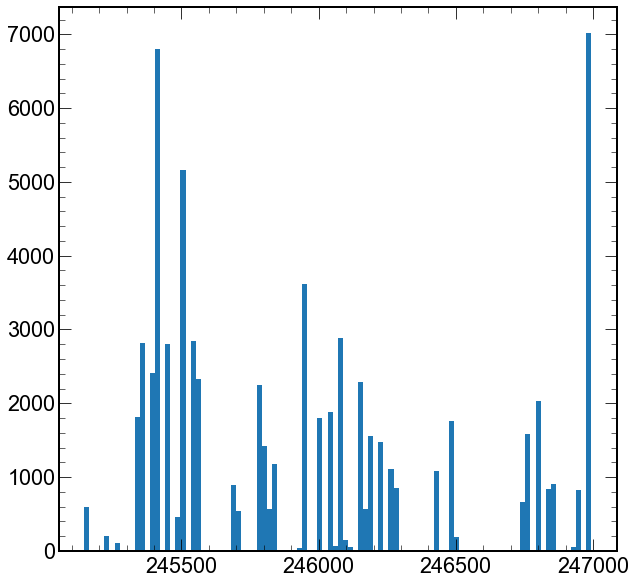

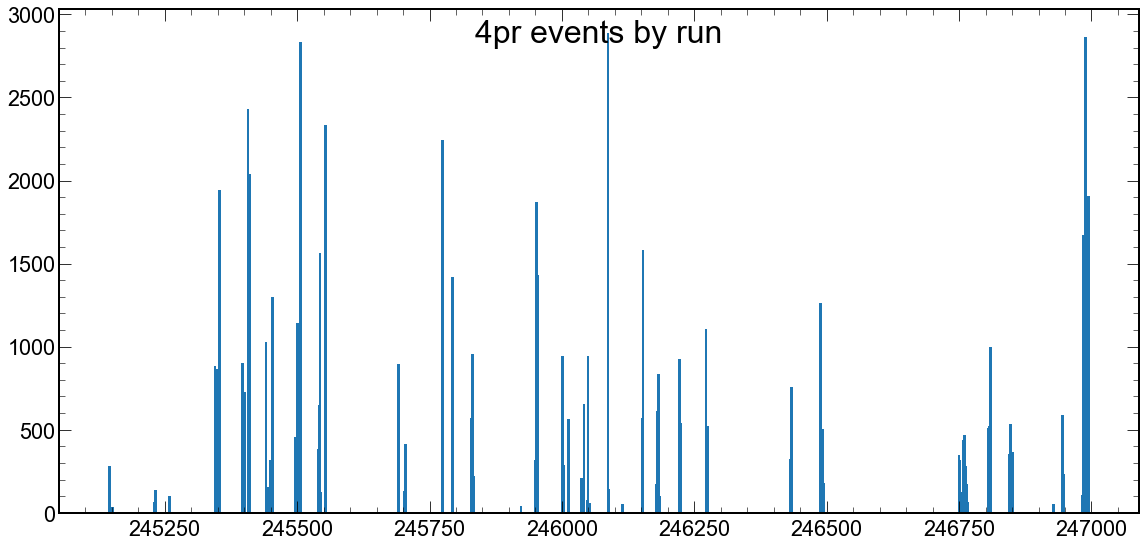

In [229]:
# print (np.unique(data['RunNum']))

runs = data['RunNum'][GoodEvents]

counts = plt.hist(runs,bins=len(np.unique(runs)))

bins = []
counts = []

for run in np.unique(runs):
    bins.append(run)
    counts.append((data['RunNum'][GoodEvents] == run).sum())
    print(run, (data['RunNum'][GoodEvents] == run).sum())

plt.style. use(hep.style.ROOT)
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle('4pr events by run', fontsize=32)
ax.bar(bins,counts,width=5 )
# ax.set_xticks(bins)
# ax.set_xticklabels(bins,rotation=90, rotation_mode="anchor", ha="right")
plt.show()



## Selection criteria:

These criteria were applied on the selection stage:

Events:

    * Zero cumulative charge 
    * at least four tracks satisfy track selection criteria.
    
Tracks:

    * Has Point On inner or outer ITS Layer
    * dca1 < 2 and dca0 < (0.0182 + 0.0350 / TMath::Power(trk->Pt(), 1.01));

## Analysis criteria:

These criteria will apply for the selected data:

    * numbers of ITS clusters more then 3
    * not ITS SA


In [2]:
select    = (data['T_ITSNCls'] > 3) * (~newT_ITSsa)

selectTpc = data['T_TPCRefit'] * (data['T_TPCNCls'] > 50) * (np.abs(data['T_NumberOfSigmaTPCPion']) < 3)

def GetGoodEvents(TrackNum=4, ChargeEqualCondition=True, charge=0, WithGoodNTpcTracks=0):
    GoodEvents = np.argwhere(select.sum()==TrackNum).flatten() # get events with 4 good tracks
    
    # get number of events with more than 'WithGoodNTpcTracks' tracks that satisfied 'selectTpc' criteria
    GoodEventsTpc = np.argwhere(selectTpc.sum() >= WithGoodNTpcTracks).flatten()

    # add at least n tracks with tpc to selected
    GoodEvents = np.intersect1d(GoodEvents,GoodEventsTpc).flatten()
    
    # get events that have total charge from 4 tracks 
    if ChargeEqualCondition:
        GoodEvents = GoodEvents[np.argwhere(data['T_Q'][select][GoodEvents].sum()==charge).flatten()].flatten()  # get good events witch total charge zero
    else:
        GoodEvents = GoodEvents[np.argwhere(data['T_Q'][select][GoodEvents].sum()!=charge).flatten()].flatten()  # get good events witch total charge non zero

    return GoodEvents

## Data validation

### Duplicates

Cause of some reasons AliESD could contains the same track few times.

![img](https://sun9-69.userapi.com/c855620/v855620379/242fba/B1cMRF7RoH0.jpg)

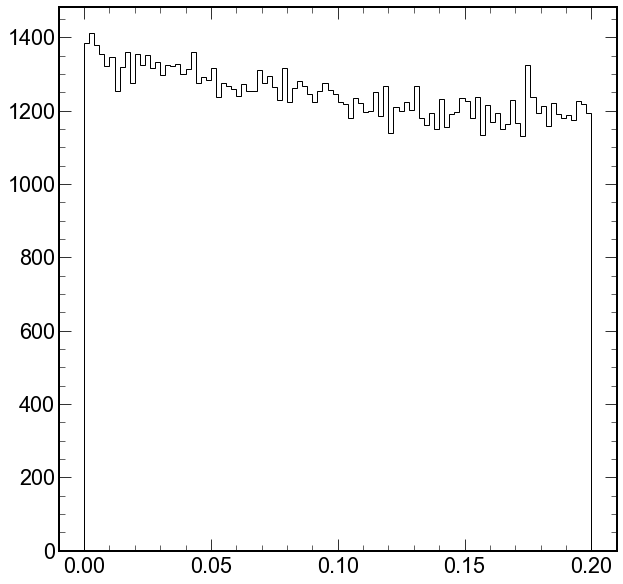

In [776]:
import math
differences = []
# GoodEvents = GetGoodEvents(TrackNum=4, WithGoodNTpcTracks=0)
# GoodEvents = GetUniqueGoodEvents()
entries = len(data['T_Px'][select])
ddpx = data['T_Px'][select]
ddpy = data['T_Py'][select]
ddpz = data['T_Pz'][select]
for event in range(entries):
    dpx = ddpx[event]
    dpy = ddpx[event]
    dpz = ddpx[event]
    N = len(dpx)
    for n in range(N):
        for j in range(n+1,N):
             
            differences.append(math.sqrt((dpx[n]-dpx[j])**2 + (dpy[n]-dpy[j])**2 + (dpz[n]-dpz[j])**2))

counts, bins = np.histogram(differences,bins=100, range=(0,0.2))
plt.style.use(hep.style.ROOT)
_ = plt.hist(differences, bins=bins, histtype='step', color='black')



## Show any parameter

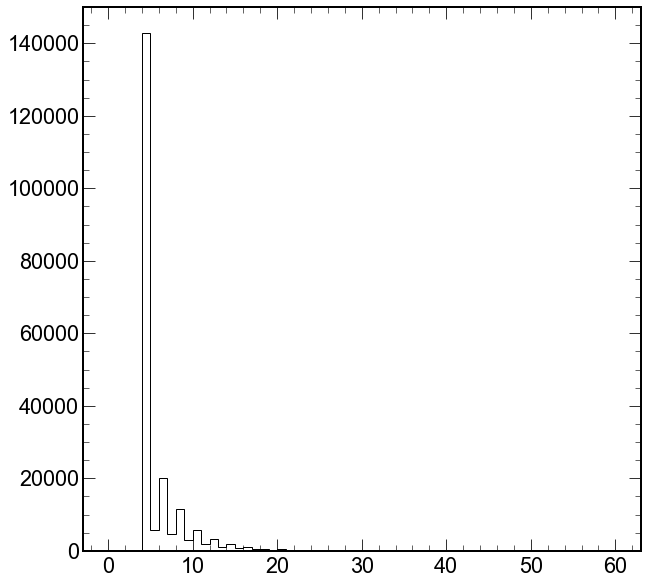

In [101]:
param = 'nTracks'
# dataParam = data[param][~newT_ITSsa].flatten() # tracks
dataParam = data[param].flatten() # events

counts, bins = np.histogram(dataParam,bins=60, range=(0,60))
plt.style.use(hep.style.ROOT)
_= plt.hist(dataParam, bins=bins, histtype='step', color='black', label=f'Entries {np.sum(counts)}')


## Pt

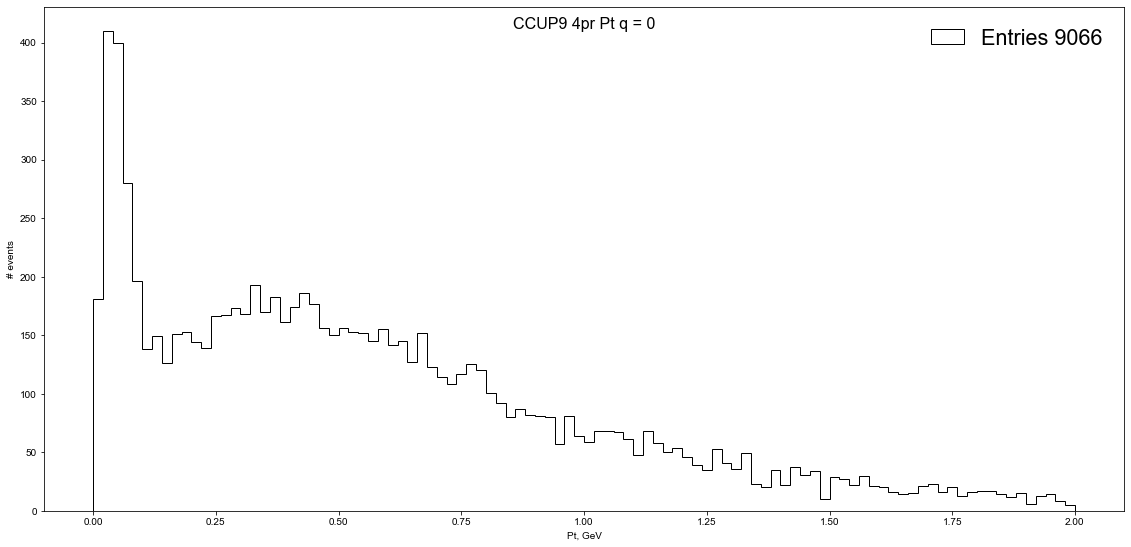

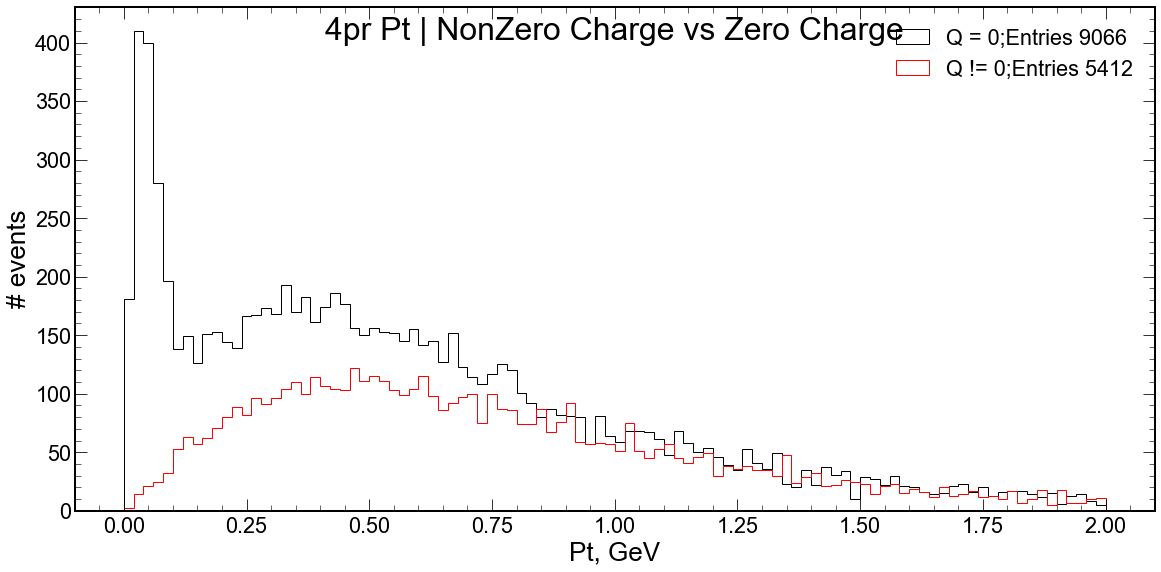

In [3]:
def GetPt(Draw=True, ChargeEqualCondition=True):
    pxg = data['T_Px'][select][GoodEvents]
    pyg = data['T_Py'][select][GoodEvents]
    
    pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)
    
    if Draw:
        counts, bins = np.histogram(pt,bins=100, range=(0,2))
        fig = plt.figure(figsize=(15, 7))
        ax = fig.add_axes([0,0,1,1])
        fig.suptitle('CCUP9 4pr Pt q = 0', fontsize=16)
        if ChargeEqualCondition:
            fig.suptitle('CCUP9 4pr Pt q = 0', fontsize=16)
        else:
            fig.suptitle('CCUP9 4pr Pt q != 0', fontsize=16)
            
        plt.style.use(hep.style.ROOT)
        ax.hist(pt, bins=bins, histtype='step', color='black', label=f'Entries {np.sum(counts)}')
        plt.xlabel('Pt, GeV')
        plt.ylabel('# events')
        ax.legend()
    else:
        return pt
    
GoodEvents = GetGoodEvents()
GetPt()

## Zero charge vs Non zero charge
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Pt | NonZero Charge vs Zero Charge', fontsize=32)
plt.style.use(hep.style.ROOT)
GoodEvents = GetGoodEvents(WithGoodNTpcTracks=0)
ptzq = GetPt(Draw=False)
counts, bins = np.histogram(ptzq, bins=100, range=(0,2))
_ = ax.hist(ptzq, bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
GoodEvents = GetGoodEvents(WithGoodNTpcTracks=0,ChargeEqualCondition=False)
ptnzq = GetPt(Draw=False,ChargeEqualCondition=False)
counts, bins = np.histogram(ptnzq, bins=100, range=(0,2))
_ = ax.hist(ptnzq, bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
plt.xlabel('Pt, GeV')
plt.ylabel('# events')
ax.legend()

## Mass

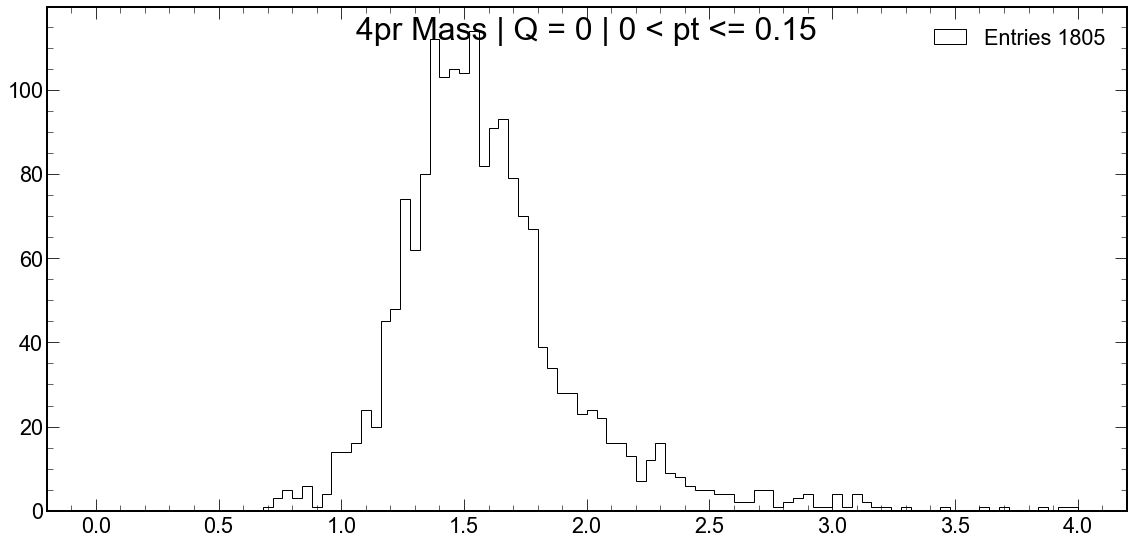

In [210]:
def GetMass(ptMin=0, ptMax=0.15, Draw=True, ChargeEqualCondition=True):
    pxg = data['T_Px'][select][GoodEvents]
    pyg = data['T_Py'][select][GoodEvents]
    pzg = data['T_Pz'][select][GoodEvents]
    massPion = np.full(pxg.shape[0], 0.140)
    pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)

    Energy0 = np.sqrt(massPion**2 + pxg[:,0]**2 + pyg[:,0]**2 + pzg[:,0]**2)
    Energy1 = np.sqrt(massPion**2 + pxg[:,1]**2 + pyg[:,1]**2 + pzg[:,1]**2)
    Energy2 = np.sqrt(massPion**2 + pxg[:,2]**2 + pyg[:,2]**2 + pzg[:,2]**2)
    Energy3 = np.sqrt(massPion**2 + pxg[:,3]**2 + pyg[:,3]**2 + pzg[:,3]**2)

    Energy = Energy0 + Energy1 + Energy2 + Energy3
    
    Mass = np.sqrt(Energy**2 - pxg.sum()**2 - pyg.sum()**2 - pzg.sum()**2)[(pt>ptMin)*(pt<=ptMax)]
    
    if Draw:
        fig = plt.figure(figsize=(15, 7))
        ax = fig.add_axes([0,0,1,1])
        if ChargeEqualCondition:
            fig.suptitle(f'4pr Mass | Q = 0 | {ptMin} < pt <= {ptMax}', fontsize=32)
        else:
            fig.suptitle(f'4pr Mass | Q != 0 | {ptMin} < pt <= {ptMax}', fontsize=32)
        plt.style.use(hep.style.ROOT)
        counts, bins = np.histogram(Mass, bins=100, range=(0,4))
        _ = ax.hist(Mass, bins=bins, color='black', histtype='step', label=f'Entries {np.sum(counts)}')
        ax.legend()
    else:
        return Mass
GoodEvents = GetGoodEvents()     
GetMass()

## Mass - pt - charge distirbution

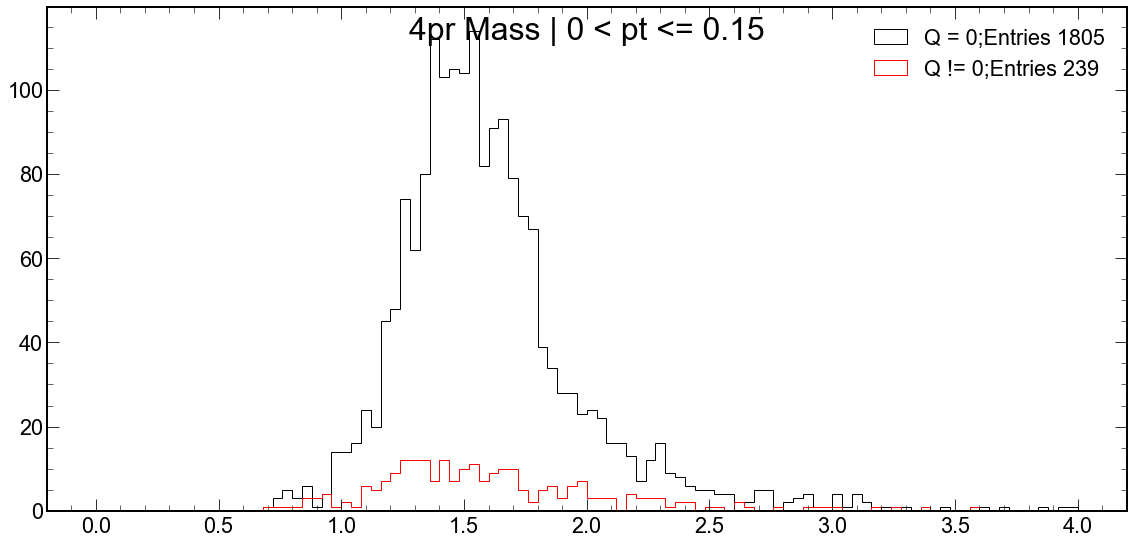

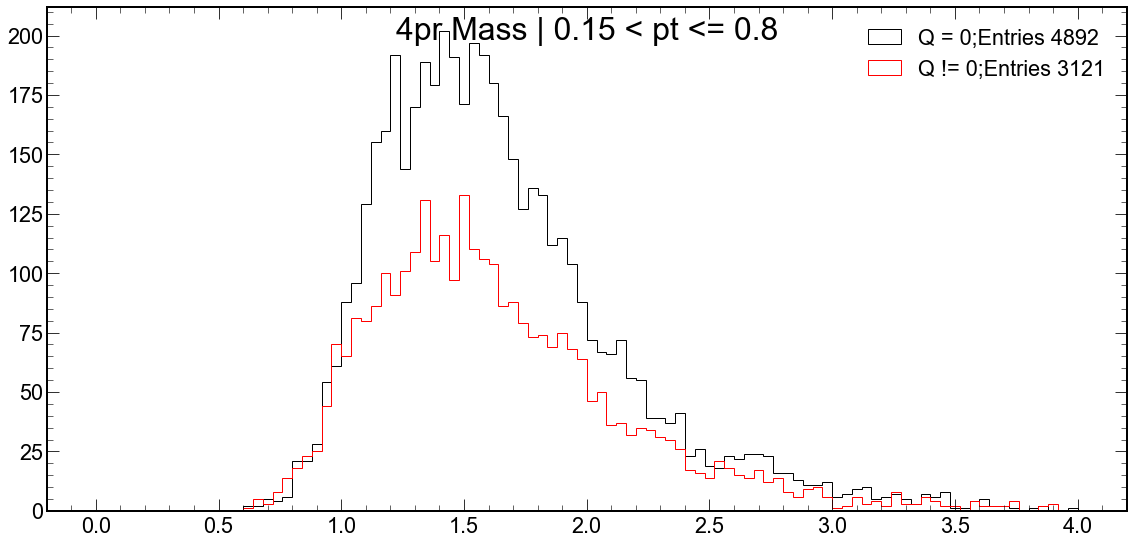

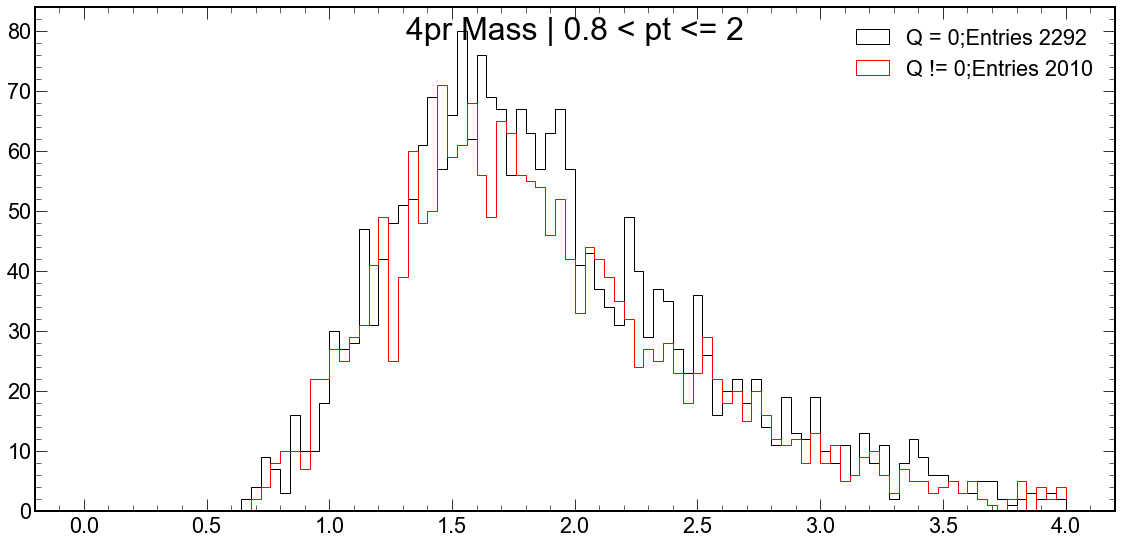

In [211]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Mass | {0} < pt <= {0.15}', fontsize=32)
plt.style.use(hep.style.ROOT)
GoodEvents = GetGoodEvents()
counts, bins = np.histogram(GetMass(Draw=False), bins=100, range=(0,4))
_ = ax.hist(GetMass(Draw=False), bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
GoodEvents = GetGoodEvents(ChargeEqualCondition=False)
counts, bins = np.histogram(GetMass(ChargeEqualCondition=False,Draw=False), bins=100, range=(0,4))
_ = ax.hist(GetMass(ChargeEqualCondition=False,Draw=False), bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
ax.legend()

fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Mass | {0.15} < pt <= {0.8}', fontsize=32)
plt.style.use(hep.style.ROOT)
GoodEvents = GetGoodEvents()
counts, bins = np.histogram(GetMass(Draw=False, ptMin=0.15, ptMax=0.8), bins=100, range=(0,4))
_ = ax.hist(GetMass(Draw=False,ptMin=0.15, ptMax=0.8), bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
GoodEvents = GetGoodEvents(ChargeEqualCondition=False)
counts, bins = np.histogram(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.15, ptMax=0.8), bins=100, range=(0,4))
_ = ax.hist(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.15, ptMax=0.8), bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
ax.legend()

fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr Mass | {0.8} < pt <= {2}', fontsize=32)
plt.style.use(hep.style.ROOT)
GoodEvents = GetGoodEvents()
counts, bins = np.histogram(GetMass(Draw=False, ptMin=0.8, ptMax=2), bins=100, range=(0,4))
_ = ax.hist(GetMass(Draw=False,ptMin=0.8, ptMax=2), bins=bins, color='black', histtype='step', label=f'Q = 0;Entries {np.sum(counts)}')
GoodEvents = GetGoodEvents(ChargeEqualCondition=False)
counts, bins = np.histogram(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.8, ptMax=2), bins=100, range=(0,4))
_ = ax.hist(GetMass(ChargeEqualCondition=False,Draw=False,ptMin=0.8, ptMax=2), bins=bins, color='red', histtype='step', label=f'Q != 0;Entries {np.sum(counts)}')
ax.legend()



## Estimation of TPC influence


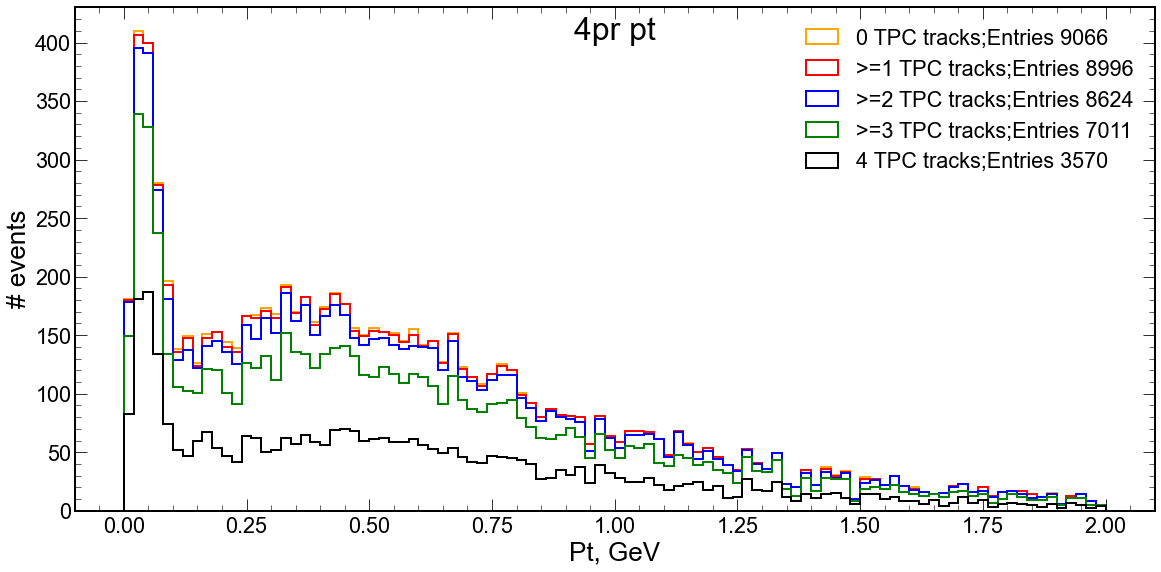

In [23]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr pt', fontsize=32)
plt.style.use(hep.style.ROOT)

GoodEvents = GetGoodEvents()
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='orange', histtype='step', label=f'0 TPC tracks;Entries {np.sum(counts)}', linewidth=2)

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=1)
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='red', histtype='step', label=f'>=1 TPC tracks;Entries {np.sum(counts)}', linewidth=2)

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=2)
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='blue', histtype='step', label=f'>=2 TPC tracks;Entries {np.sum(counts)}', linewidth=2)

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=3)
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='green', histtype='step', label=f'>=3 TPC tracks;Entries {np.sum(counts)}', linewidth=2)

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=4)
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='black', histtype='step', label=f'4 TPC tracks;Entries {np.sum(counts)}', linewidth=2)
plt.xlabel('Pt, GeV')
plt.ylabel('# events')
ax.legend()

сделать линии толще
план
    рассказываю отбор
    цель 
    вывод влияние  
        2трека без tpc заметно увеличивает статистику
        планы
        проверить корректность триггера: обеспечен ли триггер фасторами от наших треков(а не от фейков)
        

## Energy losses

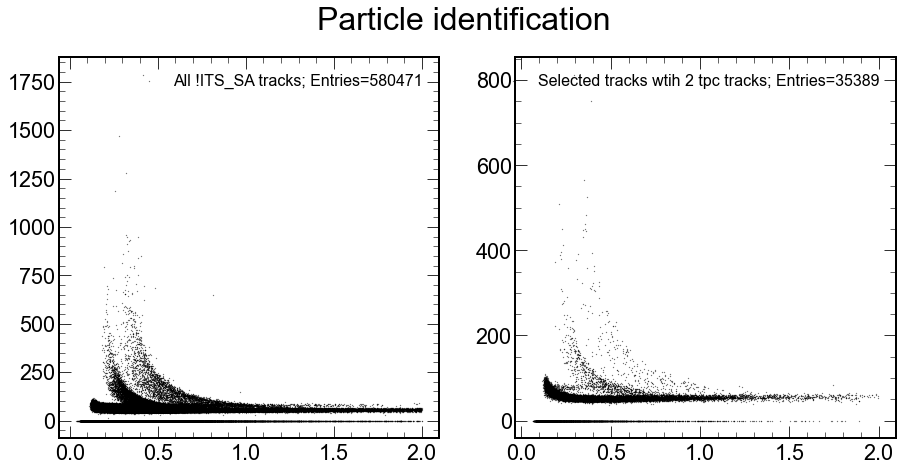

In [98]:
pt = np.sqrt(data['T_Px'][~newT_ITSsa]**2 + data['T_Py'][~newT_ITSsa]**2)
dedx = data['TPCsignal'][~newT_ITSsa][(pt<2)].flatten()
pt = pt[pt<2].flatten()

fig, ax = plt.subplots(1,2,figsize=(15, 7))
fig.suptitle(f'Particle identification', fontsize=32)
plt.style.use(hep.style.ROOT)
ax[0].scatter(pt, dedx, s=0.05, color='black', label=f'All !ITS_SA tracks; Entries={len(dedx)}')
ax[0].legend(loc=1, prop={'size': 16})

NTPCTracks = 2
GoodEvents = GetGoodEvents(WithGoodNTpcTracks=NTPCTracks)
ptTracks = np.sqrt(data['T_Px']**2 + data['T_Py']**2)[select][GoodEvents]
dedx = data['TPCsignal'][select][GoodEvents][ptTracks<2].flatten()
ptTracks = ptTracks[ptTracks<2]
ax[1].scatter(ptTracks.flatten(), dedx.flatten(), s=0.05, color = 'black',label=f'Selected tracks wtih {NTPCTracks} tpc tracks; Entries={len(dedx)}')
ax[1].legend(loc=1, prop={'size': 16})


# Debug

In [87]:
import pandas as pd

def ShowTracks(n, AllTracksInEvent=False):


    df = events.pandas.df(["T_Q", "T_P*", "*Cls", "*Refit", "RunNum", "OrbitNumber", "T_Dca1", "T_Dca0", "T_NumberOfSigmaTPCPion"], entrystart=n, entrystop=n+1)
    df.insert(10, "T_ITSsa", newT_ITSsa[n]) 
    df.insert(0, "Selected", select[n])
    pxg = data['T_Px'][select][n]
    pyg = data['T_Py'][select][n]
    
    pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)
    df.insert(4, "Pt", pt)

    if AllTracksInEvent:
        display(df)
    else:
        display(df[df['Selected']])

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=4)
print("Selected events list: \n", GoodEvents[300:350])
n=16385
ShowTracks(n, AllTracksInEvent=True)
select[n]

Selected events list: 
 [16424 16425 16456 16528 16560 16608 16635 16690 16781 16856 16919 17074
 17093 17146 17240 17246 17282 17283 17333 17403 17432 17484 17524 17737
 17738 17929 17963 17969 17981 18009 18057 18120 18168 18353 18436 18635
 18691 18767 18831 18872 18916 18924 18972 19034 19098 19200 19299 19406
 19462 19463]


Selected  T_Q       T_P     T_Phi      Pt      T_Px      T_Py  \
entry subentry                                                                  
16385 0             True    1  0.697412  0.414750  0.2877  0.587045  0.258470   
      1             True   -1  0.245319  3.363076  0.2877 -0.238746 -0.053760   
      2             True    1  0.570148  3.698432  0.2877 -0.462109 -0.287689   
      3             True   -1  0.312796  2.906150  0.2877 -0.217139  0.052090   
      4             True    1  0.119183  2.800440  0.2877 -0.086098  0.030568   
      5             True   -1  0.139337  0.014591  0.2877  0.129352  0.001887   
      6            False    1  0.555702  3.698828  0.2877 -0.450321 -0.280597   
      7            False    1  0.738164  0.414094  0.2877  0.621532  0.273168   
      8            False    1  0.119183  2.800440  0.2877 -0.086098  0.030568   
      9            False   -1  0.139337  0.014591  0.2877  0.129352  0.001887   

                    T_Pz  T_TPCNCls  T_ITSNCls  T_TPCRefit  T_ITSRefit  \
entry subentry                                                           
16385 0        -0.273780        156          6        True        True   
      1        -0.017069        144          5        True        True   
      2         0.169583        143          6        True        True   
      3         0.219040        126          4        True        True   
      4        -0.076532          0          6       False        True   
      5        -0.051762          0          5       False        True   
      6         0.165168          0          6       False        True   
      7        -0.289765          0          6       False        True   
      8        -0.076532          0          6       False        True   
      9        -0.051762          0          5       False        True   

                T_ITSsa  RunNum  OrbitNumber    T_Dca1    T_Dca0  \
entry subentry                                                     
16385 0           False  245505     11318147  0.012349 -0.002655   
      1           False  245505     11318147  0.013795  0.013437   
      2           False  245505     11318147  0.005086 -0.003443   
      3           False  245505     11318147 -0.014798 -0.047145   
      4           False  245505     11318147 -0.004357 -0.056447   
      5           False  245505     11318147  0.046101  0.072447   
      6            True  245505     11318147  0.006027 -0.004457   
      7            True  245505     11318147  0.012005 -0.001131   
      8            True  245505     11318147 -0.004357 -0.056447   
      9            True  245505     11318147  0.046101  0.072447   

                T_NumberOfSigmaTPCPion  
entry subentry                          
16385 0                      -1.110654  
      1                      -1.458411  
      2                      -0.742118  
      3                      -0.501260  
      4                    -999.000000  
      5                    -999.000000  
      6                    -999.000000  
      7                    -999.000000  
      8                    -999.000000  
      9                    -999.000000

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False])

3681 6005


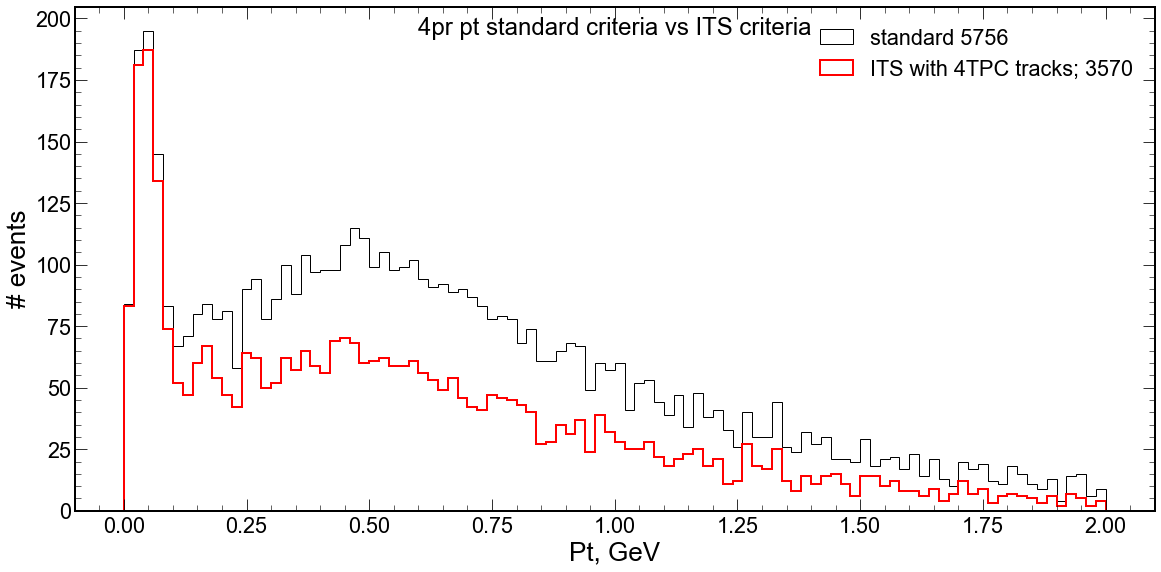

In [5]:
selectOnlyStandard    = data['T_TPCRefit']  * (data['T_TPCNCls'] > 50) * \
            (data['T_ITSNCls'] > 3) * \
            (~newT_ITSsa) * (np.abs(data['T_NumberOfSigmaTPCPion']) < 3)
GoodEventsStandard = np.argwhere(selectOnlyStandard.sum()==4).flatten() # get events with 4 good tracks
GoodEventsStandard = GoodEventsStandard[np.argwhere(data['T_Q'][selectOnlyStandard][GoodEventsStandard].sum()==0).flatten()].flatten()  

pxstd = data['T_Px'][selectOnlyStandard][GoodEventsStandard]
pystd = data['T_Py'][selectOnlyStandard][GoodEventsStandard]
    
ptstd = np.sqrt(pxstd.sum()**2  + pystd.sum()**2)

fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'4pr pt standard criteria vs ITS criteria', fontsize=24)
plt.style.use(hep.style.ROOT)
counts, bins = np.histogram(ptstd, bins=100, range=(0,2))
_ = ax.hist(ptstd, bins=bins, color='black', histtype='step', label=f'standard {np.sum(counts)}')
plt.xlabel('Pt, GeV')
plt.ylabel('# events')
ax.legend()

GoodEvents = GetGoodEvents(WithGoodNTpcTracks=4)
counts, bins = np.histogram(GetPt(Draw=False), bins=100, range=(0,2))
_ = ax.hist(GetPt(Draw=False), bins=bins, color='red', histtype='step', label=f'ITS with 4TPC tracks; {np.sum(counts)}', linewidth=2)
plt.xlabel('Pt, GeV')
plt.ylabel('# events')
ax.legend()

print(len(GoodEvents), len(GoodEventsStandard))

2527 146


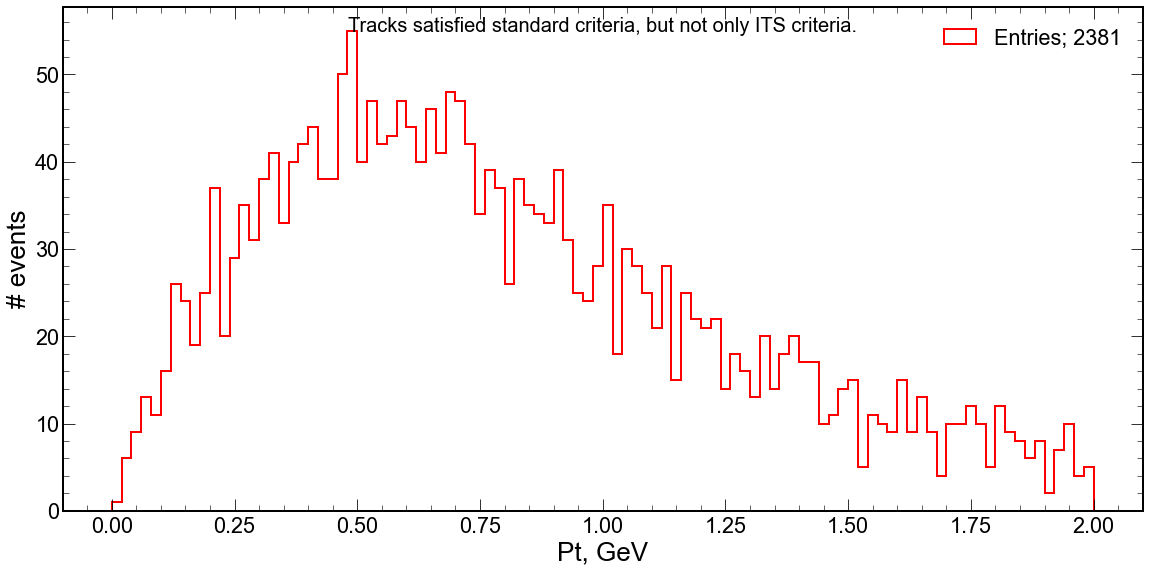

In [22]:
diff = list(set(GoodEventsStandard) - set(GoodEvents))

pxg = data['T_Px'][selectOnlyStandard][diff]
pyg = data['T_Py'][selectOnlyStandard][diff]
    
pt = np.sqrt(pxg.sum()**2  + pyg.sum()**2)

print(len(pt),(pt > 2).sum())

fig = plt.figure(figsize=(15, 7))
ax = fig.add_axes([0,0,1,1])
fig.suptitle(f'Tracks satisfied standard criteria, but not only ITS criteria.', fontsize=20)
plt.style.use(hep.style.ROOT)
counts, bins = np.histogram(pt, bins=100, range=(0,2))
_ = plt.hist(pt, bins=bins, color='red', histtype='step', label=f'Entries; {np.sum(counts)}', linewidth=2)
plt.xlabel('Pt, GeV')
plt.ylabel('# events')
ax.legend()
# 2186